In [1]:
import os
import copy
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from aml_io.convert_tools import cart2pol
from aml_dl.mdn.model.tf_mdn_model import MixtureDensityNetwork

In [2]:
def fun_h(t, noise_gain=0.):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
    return np.cos(2*t - 1/2)/2 + np.cos(t) + 2 + noise

def fun_g(r, noise_gain=0.):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
    noise = noise_gain*np.random.randn(d1, d2)
    return np.divide(np.power(np.multiply((np.sin(r) - np.sin(2*r)/2 + np.sin(3*r)/3. - 
                                           np.sin(4*r)/4. + 4),r),2),(r+1)) + noise

def sawtoothxy(x,y):
    t, r = cart2pol(x,y) # change to polar coordinates
    h = fun_h(t)
    g = fun_g(r)
    f = np.multiply(g,h)
    return f

In [3]:
def create_data_points(data, noise=0.01):
    pass
    

In [4]:
num_data_points = 2500
x_values = np.linspace(0, 6, num_data_points)
y_values = fun_h(x_values, 0.1)

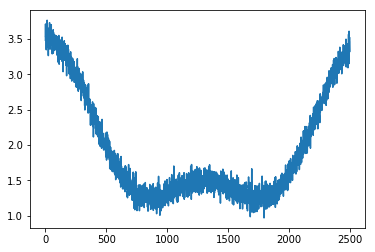

In [5]:
plt.figure()
plt.plot(y_values)
plt.show()

MDN

In [6]:
#hyperparams
EXP_NAME = 'exp_ensemble'

check_point_dir   = os.environ['AML_DATA'] + '/aml_dl/mdn/tf_check_points/exp_ensemble/'
summary_dir = os.environ['AML_DATA'] + '/aml_dl/mdn/summaries/exp_ensemble/'

if not os.path.exists(check_point_dir):
    os.makedirs(check_point_dir)

if not os.path.exists(summary_dir):
    os.makedirs(summary_dir)

adam_params = {
    'type': 'adam',
    'params': {'learning_rate' : 0.0001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'use_locking': False}
}

network_params = {
    'dim_input': 1, 
    'dim_output': 1,
    'n_hidden': 48,
    'k_mixtures': 20,
    'write_summary': False,
    'load_saved_model': False,
    'model_dir': check_point_dir + '/inv/',
    'model_name':'ensemble_model_inv_10_kernels.ckpt',
    'optimiser': adam_params,
    'summary_dir':summary_dir+'/inv/',
    'device': '/cpu:0',
}

EPOCHS = 10000

In [7]:
#training data
x_train = x_values[:,None]
y_train = y_values[:,None]

tf_sumry_wrtr = None

In [8]:
#computational graph
mdn = MixtureDensityNetwork(network_params, tf_sumry_wrtr = tf_sumry_wrtr)
mdn._init_model()

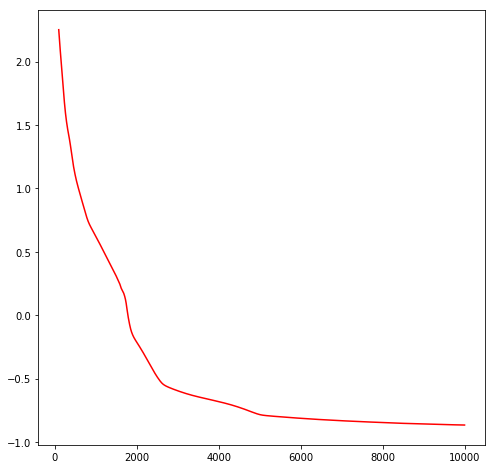

In [9]:
#training session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

with tf.device(network_params['device']):
    # Keeping track of loss progress as we train
    loss = np.zeros(EPOCHS) 

    train_op = mdn._ops['train']
    loss_op  = mdn._ops['loss']
    
    for i in range(EPOCHS):
        sess.run(train_op,feed_dict={mdn._ops['x']: x_train, mdn._ops['y']: y_train})
        _, loss[i] = sess.run([train_op, loss_op], feed_dict={mdn._ops['x']: x_train, mdn._ops['y']: y_train})

plt.figure(figsize=(8, 8))
plt.plot(np.arange(100, EPOCHS,1), loss[100:], 'r-')
plt.show()

In [10]:
#testing session
x_test = np.float32(np.arange(3,9,0.1))
y_test = fun_h(x_test, 0.0)

mu_out    = mdn.run_op(sess=sess, op='mu',    xs=x_test[:,None])
sigma_out = mdn.run_op(sess=sess, op='sigma', xs=x_test[:,None])
pi_out    = mdn.run_op(sess=sess, op='pi',    xs=x_test[:,None])

max_ids   = np.argmax(pi_out[0], axis=1)

pred_mu = []
for i in range(len(max_ids)):
    pred_mu.append(mu_out[0][i, :, max_ids[i]])

pred_sigma = []
for i in range(len(max_ids)):
    pred_sigma.append(sigma_out[0][i, max_ids[i]])

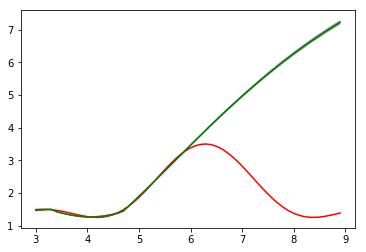

In [11]:
#plot results
stddev = 3.

fig=plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_test, y_test, color='r')

ypl = [float(mu-stddev*sig) for mu,sig in zip(pred_mu,pred_sigma)]
yph = [float(mu+stddev*sig) for mu,sig in zip(pred_mu,pred_sigma)]

ax.fill_between(x_test.tolist(), ypl, yph, facecolor='grey', interpolate=True, alpha=0.9)
ax.plot(x_test, pred_mu, color='g') 

plt.show()

ENSEMBLES

In [12]:
def add_adversarial_examples(data, loss_grad, epsilon=0.0001, no_examples=50):
    
    rand_indices = [random.randint(0,len(data)-1) for _ in range(no_examples)]

    for index in rand_indices:
        data[index,:] += epsilon*np.sign(loss_grad[index])

    return data
    

In [13]:
#hyperparams
NO_ENSEMBLES = 5

In [14]:
#create ensembles
mdn_ensembles = [MixtureDensityNetwork(network_params, tf_sumry_wrtr = tf_sumry_wrtr) for _ in range(NO_ENSEMBLES)]
for k in range(NO_ENSEMBLES):
    mdn_ensembles[k]._init_model()

In [15]:
#training session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

with tf.device(network_params['device']):
    # Keeping track of loss progress as we train
    loss = np.zeros([NO_ENSEMBLES, EPOCHS])
    
    for i in range(EPOCHS):
        #train them parrallely
        for k in range(NO_ENSEMBLES):
            train_op = mdn_ensembles[k]._ops['train']
            loss_op  = mdn_ensembles[k]._ops['loss']
            grad_op  = mdn_ensembles[k]._ops['loss_grad']
            
            #compute value of the gradients
            loss_grad = sess.run(grad_op,feed_dict={mdn_ensembles[k]._ops['x']: x_train, mdn_ensembles[k]._ops['y']: y_train})
            
            #get adversarial examples
            x_train = add_adversarial_examples(data=x_train, loss_grad=loss_grad)
            
            sess.run(train_op,feed_dict={mdn_ensembles[k]._ops['x']: x_train, mdn_ensembles[k]._ops['y']: y_train})
            _, loss[k,i] = sess.run([train_op, loss_op], feed_dict={mdn_ensembles[k]._ops['x']: x_train, mdn_ensembles[k]._ops['y']: y_train})

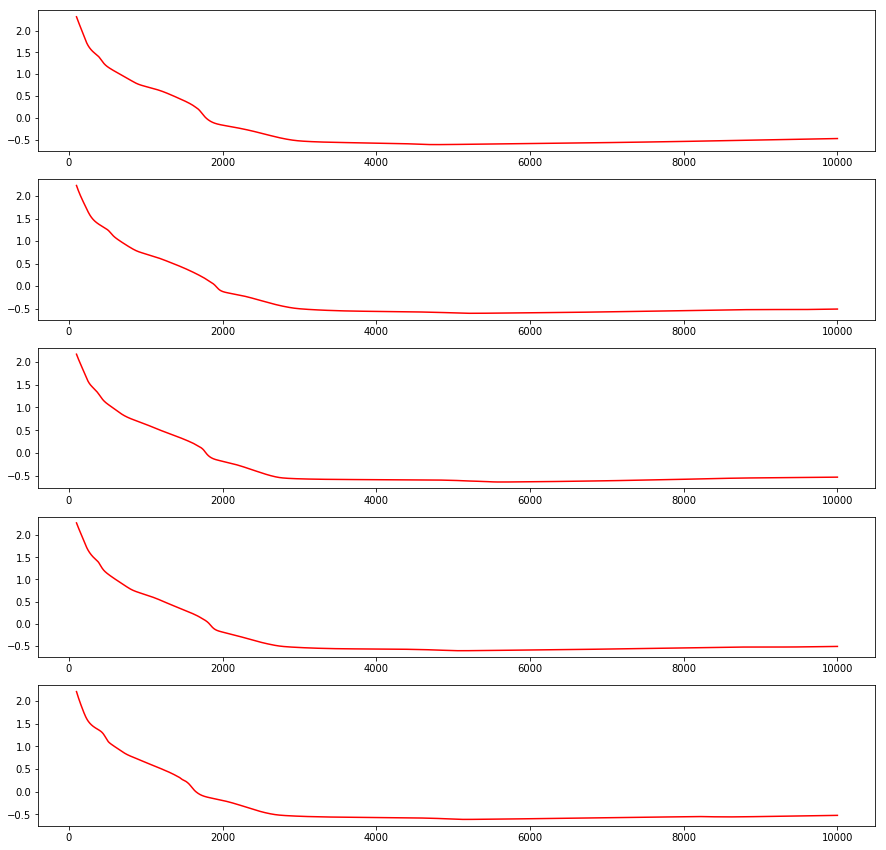

In [16]:
#plot loss curves
plt.figure(figsize=(15,15))
plot_no=NO_ENSEMBLES*100+11
for k in range(NO_ENSEMBLES):
    plt.subplot(plot_no)
    plt.plot(np.arange(100, EPOCHS,1), loss[k, 100:], 'r-')
    plot_no += 1
plt.show()

In [17]:
#testing

mu_out_ensembles    = [mdn_ensembles[k].run_op(sess=sess, op='mu',    xs=x_test[:,None]) for k in range(NO_ENSEMBLES)]
sigma_out_ensembles = [mdn_ensembles[k].run_op(sess=sess, op='sigma', xs=x_test[:,None]) for k in range(NO_ENSEMBLES)]
pi_out_ensembles    = [mdn_ensembles[k].run_op(sess=sess, op='pi',    xs=x_test[:,None]) for k in range(NO_ENSEMBLES)]

max_ids_ensembles = [np.argmax(pi_out_ensembles[k][0], axis=1) for k in range(NO_ENSEMBLES)]

pred_mu_ensembles = []
pred_sigma_ensembles = []

for k in range(NO_ENSEMBLES):
    max_ids = max_ids_ensembles[k]
    pred_mu = []
    for i in range(len(max_ids)):
        pred_mu.append(mu_out[0][i, :, max_ids[i]])

    pred_sigma = []
    for i in range(len(max_ids)):
        pred_sigma.append(sigma_out[0][i, max_ids[i]])
    
    pred_mu_ensembles.append(copy.deepcopy(pred_mu))
    pred_sigma_ensembles.append(copy.deepcopy(pred_sigma))

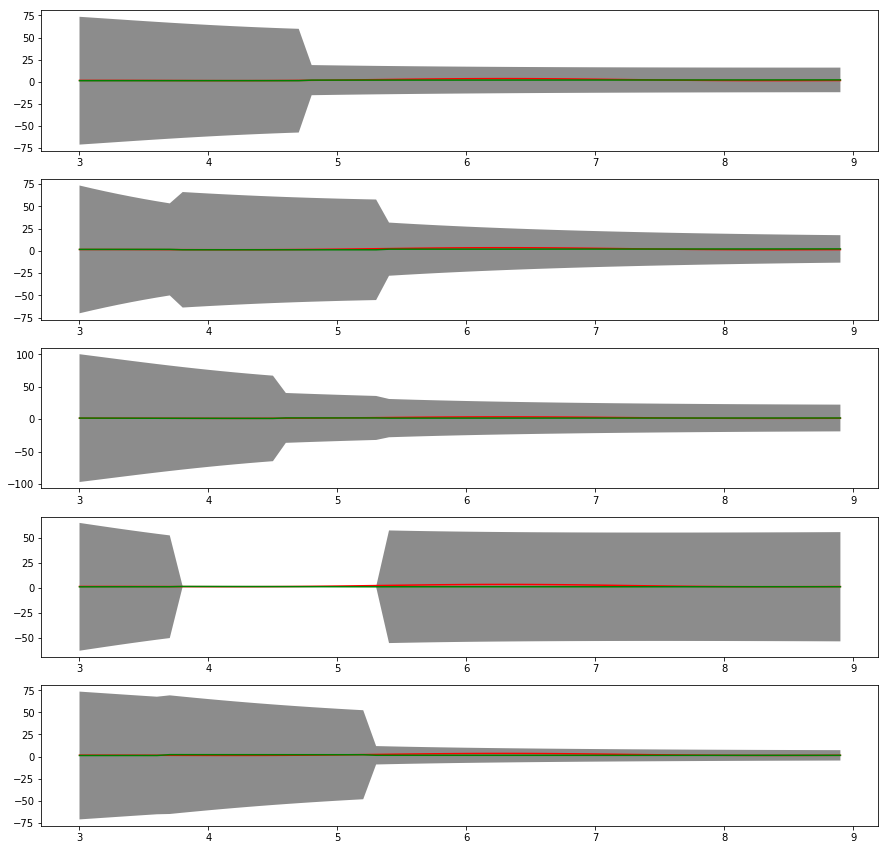

In [18]:
#plot results, [here the results are not combined, but rather checked]
stddev = 20.

fig=plt.figure(figsize=(15,15))
plot_no=NO_ENSEMBLES*100+11

for k in range(NO_ENSEMBLES):
    pred_mu = pred_mu_ensembles[k]
    pred_sigma = pred_sigma_ensembles[k]
    ax = fig.add_subplot(plot_no)
    ax.plot(x_test, y_test, color='r')
    
    ypl = [float(mu-stddev*sig) for mu,sig in zip(pred_mu,pred_sigma)]
    yph = [float(mu+stddev*sig) for mu,sig in zip(pred_mu,pred_sigma)]

    ax.fill_between(x_test.tolist(), ypl, yph, facecolor='grey', interpolate=True, alpha=0.9)
    ax.plot(x_test, pred_mu, color='g')
    
    plot_no += 1

plt.show()